In [8]:
FIXED_PT = True
ON_CHIP = False

assert not (not FIXED_PT and ON_CHIP), 'chip must use fixed point'

In [9]:
from nir.read import read
from nir.ir import LIF

graph = read('lif_norse.nir')
for nkey, node in graph.nodes.items():
    print(f"{nkey:7} {node}")

0       Affine(weight=array([[1.]], dtype=float32), bias=array([0.], dtype=float32))
1       LIF(tau=array([0.0025], dtype=float32), r=array([1.], dtype=float32), v_leak=array([0.], dtype=float32), v_threshold=array([0.1], dtype=float32))
input   Input(input_type={'input': array([1])})
output  Output(output_type={'output': array([1])})


In [10]:
import numpy as np

isis = [
    6, 15, 4, 3, 0, 2, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 
    0, 0, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 14
]
d1 = list(np.concatenate([isi*[0]+[1] for isi in isis]))[:100]
d = np.array([[e] + 9*[0] for e in d1]).reshape(1, -1)

In [11]:
# default timestep (e.g. norse)
dt = 1e-4

# voltage leak: dv = dt / tau
tau_mem = graph.nodes['1'].tau
dv = dt / tau_mem

vthr = graph.nodes['1'].v_threshold  # * 10

# no current leak
tau_syn = None  # 1/200
du = 1.0  # no current leak

correction = dt / graph.nodes['1'].tau

w = np.ones((1, 1))
w *= correction

print(f'\tdt: {dt}, tau_mem: {tau_mem}, tau_syn: {tau_syn}')
print(f'\tdv: {dv}, du: {du}, vthr: {vthr}')
print(f'\tw correction term: {correction}')

if FIXED_PT:
    # discretization
    print('discretized')
    dv = int(dv * 4095)
    du = int(du * 4095)
    vthr = int(vthr * 131071) >> 9
    w = (w * 256).astype(np.int32)

    print(f'\tdv: {dv}, du: {du}, vthr: {vthr}')
    print(f'\tw: {w}')

	dt: 0.0001, tau_mem: [0.0025], tau_syn: None
	dv: [0.04], du: 1.0, vthr: [0.1]
	w correction term: [0.04]
discretized
	dv: 163, du: 4095, vthr: 25
	w: [[10]]


In [5]:
from lava.proc.io.source import RingBuffer
from lava.proc.lif.process import LIF
from lava.proc.dense.process import Dense

ring_buffer = RingBuffer(data=d)
dense = Dense(weights=w)
lif = LIF(
    shape=(1,),
    # u=0.,
    # v=0.,
    du=du,
    dv=dv,
    vth=vthr,
    # no bias
    bias_mant=0,
    bias_exp=0,
    name='lif'
)

if ON_CHIP:
    from lava.proc.io.sink import RingBuffer as Sink
    from lava.proc.embedded_io.spike import PyToNxAdapter, NxToPyAdapter

    sink = Sink(shape=(1,), buffer=d.shape[1])
    py2nx = PyToNxAdapter(shape=(1,))
    nx2py = NxToPyAdapter(shape=(1,))

    ring_buffer.s_out.connect(py2nx.inp)
    py2nx.out.connect(dense.s_in)
    dense.a_out.connect(lif.a_in)
    lif.s_out.connect(nx2py.inp)
    nx2py.out.connect(sink.a_in)
else:
    dense.a_out.connect(lif.a_in)
    ring_buffer.s_out.connect(dense.s_in)

In [6]:
from lava.proc.monitor.process import Monitor
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2SimCfg, Loihi1SimCfg, Loihi2HwCfg, Loihi1HwCfg

n_steps = 1000

if ON_CHIP:
    from lava.utils.loihi2_state_probes import StateProbe

    probe_v = StateProbe(lif.v)
    probe_u = StateProbe(lif.u)
    callbacks = [probe_v, probe_u]
    run_cfg = Loihi2HwCfg(callback_fxs=callbacks)
else:
    mon_volt = Monitor()
    mon_curr = Monitor()
    mon_spk = Monitor()
    mon_inp = Monitor()
    mon_volt.probe(lif.v, n_steps)
    mon_curr.probe(lif.u, n_steps)
    mon_spk.probe(lif.s_out, n_steps)
    mon_inp.probe(ring_buffer.s_out, n_steps)

    tag = "fixed_pt" if FIXED_PT else "floating_pt"
    run_cfg = Loihi2SimCfg(select_tag=tag)

print('start running')
lif.run(condition=RunSteps(num_steps=n_steps), run_cfg=run_cfg)
print('getting data')
if ON_CHIP:
    sink_data = sink.data.get()
    lif.stop()
print('finished running')

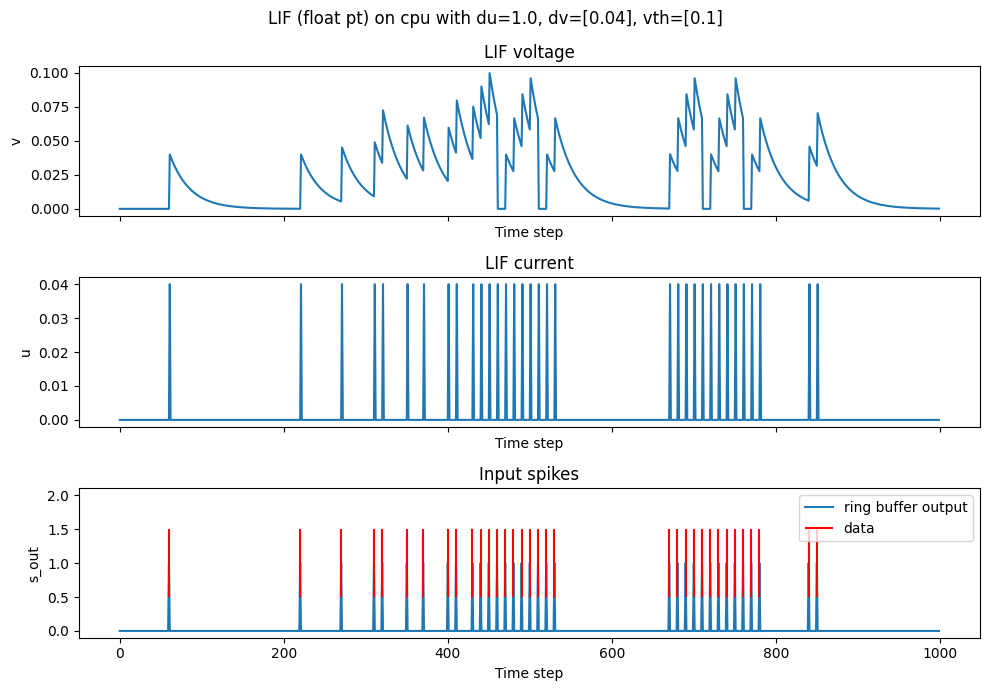

In [7]:
import matplotlib.pyplot as plt

inp_spikes = d.reshape(-1)

if ON_CHIP:
    spikes = sink_data.reshape(-1)
    voltage = probe_v.time_series.reshape(-1)
    print(f'spikes: {spikes.shape}, voltage: {voltage.shape}')
else:
    spikes = mon_spk.get_data()['lif']['s_out'].reshape(-1)
    voltage = mon_volt.get_data()['lif']['v'].reshape(-1)
    print(f'spikes: {spikes.shape}, voltage: {voltage.shape}')

sfx = 'fixed' if FIXED_PT else 'float'
device = 'loihi' if ON_CHIP else 'cpu'
with open(f'lif_lava_{device}_{sfx}.csv', 'w') as fw:
    for idx in range(inp_spikes.shape[0]):
        fw.write(f'{inp_spikes[idx]},{voltage[idx]},{spikes[idx]}\n')

fig, axs = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
fig.suptitle(f'LIF ({sfx} pt) on {device} with du={du}, dv={dv}, vth={vthr}')
mon_volt.plot(axs[0], lif.v)
mon_curr.plot(axs[1], lif.u)
mon_inp.plot(axs[2], ring_buffer.s_out, label='ring buffer output')
axs[2].eventplot(np.argwhere(d.reshape(-1) > 0).reshape(-1), color='r', label='data')
axs[2].legend()
# axs[2].set_xticks(np.arange(0, n_steps, 1), minor=True)
axs[0].set_title('LIF voltage')
axs[1].set_title('LIF current')
axs[2].set_title('Input spikes')
plt.tight_layout()
plt.savefig(f'lif_lava_{device}_{sfx}.png')
plt.show()